In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint

from sklearn.utils import shuffle

Using TensorFlow backend.


In [2]:
BASE_PATH = "./data/chest_xray/"
TRAIN_DIR = BASE_PATH + "train/"

TEST_DIR =  BASE_PATH + "test/"
LABELS = ['NORMAL', 'PNEUMONIA']

for data_dir in [TRAIN_DIR, TEST_DIR]:
    for label in LABELS:
        count = len(os.listdir(data_dir + label))
        print('{0} {1} # {2}'.format(label, data_dir, count))

NORMAL ./data/chest_xray/train/ # 1350
PNEUMONIA ./data/chest_xray/train/ # 3884
NORMAL ./data/chest_xray/test/ # 234
PNEUMONIA ./data/chest_xray/test/ # 390


In [3]:
total_train = len(os.listdir(TRAIN_DIR + 'NORMAL')) + len(os.listdir(TRAIN_DIR + 'PNEUMONIA'))
total_test = len(os.listdir(TEST_DIR + 'NORMAL')) + len(os.listdir(TEST_DIR + 'PNEUMONIA'))
(total_train, total_test)

(5234, 624)

NORMAL


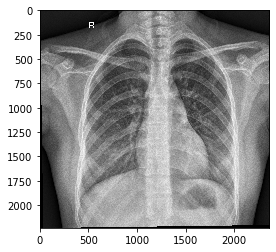

PNEUMONIA


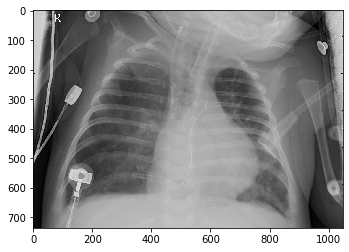

In [4]:
for label in LABELS:
    path = TRAIN_DIR + label
    img = os.listdir(path)[0]
    img_normal = load_img(path + '/' + img)
    print(label)
    plt.imshow(img_normal)
    plt.show()

In [108]:
img_width, img_height = 300, 300
batch_size = 32

In [109]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.15                                   
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale'
)

Found 5232 images belonging to 2 classes.


In [110]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale')

Found 624 images belonging to 2 classes.


In [111]:
def plt_history(history):
    plt.plot(history.history['val_acc'])    
    plt.plot(history.history['acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['test', 'train'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['val_loss'])    
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['test', 'train'], loc='upper left')
    plt.show()

In [112]:
from keras import backend as K
K.image_data_format()

'channels_last'

In [176]:
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3,3), strides=3, input_shape=(img_width, img_height, 1)))
    model.add(Conv2D(32, (3,3), strides=3))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Conv2D(64, (2,2), strides=2))
    model.add(Conv2D(64, (2,2), strides=2))
    model.add(Activation('relu'))    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
      optimizer='adam',                  
      metrics=['accuracy'])
    model.summary()
    
    return model    


In [177]:
epochs = 25
def run_model(model):
    checkpoint = ModelCheckpoint('checkpoints/checkpoint-2', monitor='val_acc', verbose=1, save_best_only=True, mode='max')    

    model.fit_generator(
        train_generator,
        steps_per_epoch=total_train // batch_size,
        epochs=epochs,
        validation_data=test_generator,
        validation_steps=total_test // batch_size,
        callbacks=[checkpoint]
    )
    return model

In [178]:
model = build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_183 (Conv2D)          (None, 100, 100, 32)      320       
_________________________________________________________________
conv2d_184 (Conv2D)          (None, 33, 33, 32)        9248      
_________________________________________________________________
activation_85 (Activation)   (None, 33, 33, 32)        0         
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_185 (Conv2D)          (None, 5, 5, 64)          8256      
_________________________________________________________________
conv2d_186 (Conv2D)          (None, 2, 2, 64)          16448     
_________________________________________________________________
activation_86 (Activation)   (None, 2, 2, 64)          0         
__________

Epoch 1/25
163/163 [==============================] - 88s 541ms/step - loss: 0.5883 - acc: 0.7437 - val_loss: 0.6499 - val_acc: 0.6385

Epoch 00001: val_acc improved from -inf to 0.63851, saving model to checkpoints/checkpoint-2
Epoch 2/25
163/163 [==============================] - 82s 502ms/step - loss: 0.4471 - acc: 0.7906 - val_loss: 0.5385 - val_acc: 0.7280

Epoch 00002: val_acc improved from 0.63851 to 0.72804, saving model to checkpoints/checkpoint-2
Epoch 3/25
163/163 [==============================] - 85s 521ms/step - loss: 0.3502 - acc: 0.8422 - val_loss: 0.6319 - val_acc: 0.6909

Epoch 00003: val_acc did not improve from 0.72804
Epoch 4/25
163/163 [==============================] - 84s 514ms/step - loss: 0.3144 - acc: 0.8587 - val_loss: 0.5369 - val_acc: 0.7584

Epoch 00004: val_acc improved from 0.72804 to 0.75845, saving model to checkpoints/checkpoint-2
Epoch 5/25
163/163 [==============================] - 86s 528ms/step - loss: 0.2758 - acc: 0.8809 - val_loss: 0.4438 - va

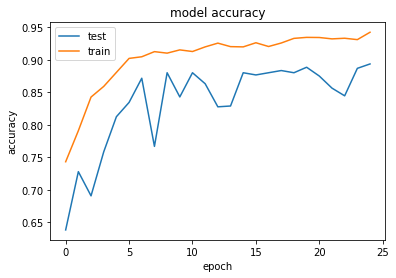

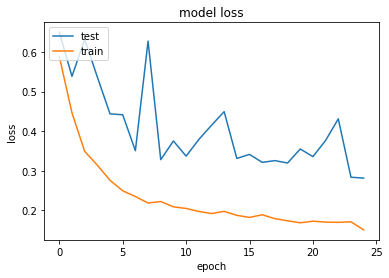

In [179]:
model = run_model(model)
plt_history(model.history)

Epoch 1/25
163/163 [==============================] - 85s 524ms/step - loss: 0.1624 - acc: 0.9362 - val_loss: 0.3327 - val_acc: 0.8801

Epoch 00001: val_acc improved from -inf to 0.88007, saving model to checkpoints/checkpoint-2
Epoch 2/25
163/163 [==============================] - 80s 489ms/step - loss: 0.1544 - acc: 0.9381 - val_loss: 0.2924 - val_acc: 0.8936

Epoch 00002: val_acc improved from 0.88007 to 0.89358, saving model to checkpoints/checkpoint-2
Epoch 3/25
163/163 [==============================] - 77s 475ms/step - loss: 0.1692 - acc: 0.9362 - val_loss: 0.2667 - val_acc: 0.8818

Epoch 00003: val_acc did not improve from 0.89358
Epoch 4/25
163/163 [==============================] - 79s 487ms/step - loss: 0.1575 - acc: 0.9387 - val_loss: 0.3852 - val_acc: 0.8564

Epoch 00004: val_acc did not improve from 0.89358
Epoch 5/25
163/163 [==============================] - 78s 477ms/step - loss: 0.1587 - acc: 0.9381 - val_loss: 0.3422 - val_acc: 0.8767

Epoch 00005: val_acc did not im

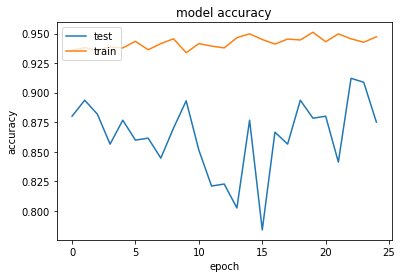

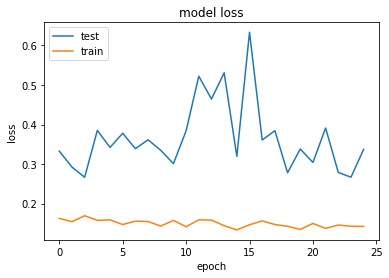

In [180]:
model = run_model(model)
plt_history(model.history)